In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import scipy.stats as stats
import warnings
from itertools import combinations

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from google.colab import files

In [3]:
# Suppress warnings for clean output
warnings.filterwarnings('ignore')


In [4]:
# Upload CSV file
uploaded = files.upload()

Saving combined_data.csv to combined_data.csv


In [5]:
# Read uploaded file into DataFrame
combined_df = pd.read_csv(list(uploaded.keys())[0])

In [6]:
# Show first few rows of the dataset
print(combined_df.head())

   Customer_Id  Gender Device_Type Customer_Type Product_Category   Product  \
0         4174    Male      Mobile     Returning        Groceries      Rice   
1         4507    Male     Desktop     Returning        Groceries     Flour   
2         1860  Female      Mobile     Returning             Toys    Puzzle   
3         2294    Male      Tablet           New         Clothing     Dress   
4         2130  Female      Mobile     Returning            Books  Textbook   

        Brand  Sales  Quantity  Discount  Profit  Shipping_Cost  \
0  Aashirvaad  35156         7        38    3522             42   
1     Fortune  32265         2        27    2699             75   
2      Mattel  17252         2        36    4763            169   
3      Adidas   2262         1         5     120            123   
4      Oxford  17877         7        11    2966            165   

  Payment_Method Order_Priority    Platform  
0         Wallet           High  E-Commerce  
1           Cash           Hig

In [7]:
# Display missing values in each column
print(combined_df.isnull().sum())

Customer_Id         0
Gender              0
Device_Type         0
Customer_Type       0
Product_Category    0
Product             0
Brand               0
Sales               0
Quantity            0
Discount            0
Profit              0
Shipping_Cost       0
Payment_Method      0
Order_Priority      0
Platform            0
dtype: int64


In [8]:
# Convert numeric columns to proper data types and fill missing values with median
numeric_cols = ['Sales', 'Profit', 'Quantity', 'Discount', 'Shipping_Cost']
combined_df[numeric_cols] = combined_df[numeric_cols].apply(pd.to_numeric, errors='coerce')
combined_df[numeric_cols] = combined_df[numeric_cols].fillna(combined_df[numeric_cols].median())

In [9]:
# List of categorical columns
cat_cols = ['Customer_Type', 'Device_Type', 'Payment_Method', 'Order_Priority', 'Platform']

# Fill missing values in categorical columns using mode
for col in cat_cols:
    if col in combined_df.columns:
        mode_value = combined_df[col].mode()
        if not mode_value.empty:
            combined_df[col] = combined_df[col].fillna(mode_value[0])
        else:
            combined_df[col] = combined_df[col].fillna('Unknown')
    else:
        print(f"⚠️ Warning: Column '{col}' not found in combined_df")

In [10]:
# Strip leading/trailing spaces from column names
combined_df.columns = combined_df.columns.str.strip()

In [11]:
# Drop duplicate rows if any
combined_df.drop_duplicates(inplace=True)

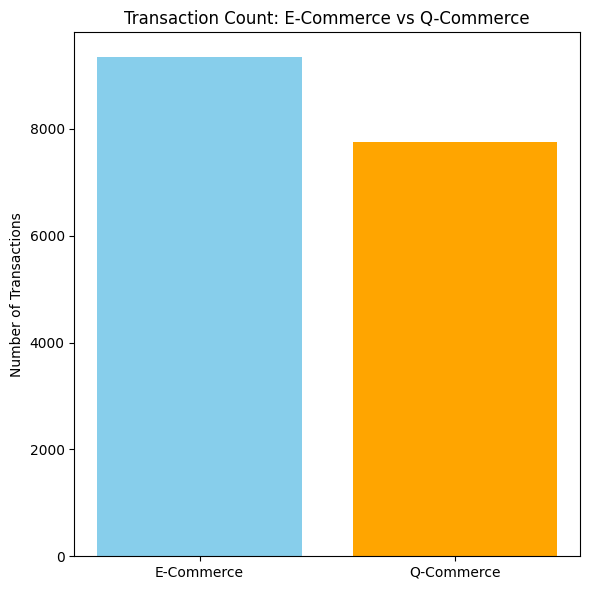

In [12]:
# Plot: Transaction count per platform
platform_counts = combined_df['Platform'].value_counts()

plt.figure(figsize=(6, 6))
plt.bar(platform_counts.index, platform_counts.values, color=['skyblue', 'orange'])
plt.ylabel('Number of Transactions')
plt.title('Transaction Count: E-Commerce vs Q-Commerce')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.grid(False)
plt.show()

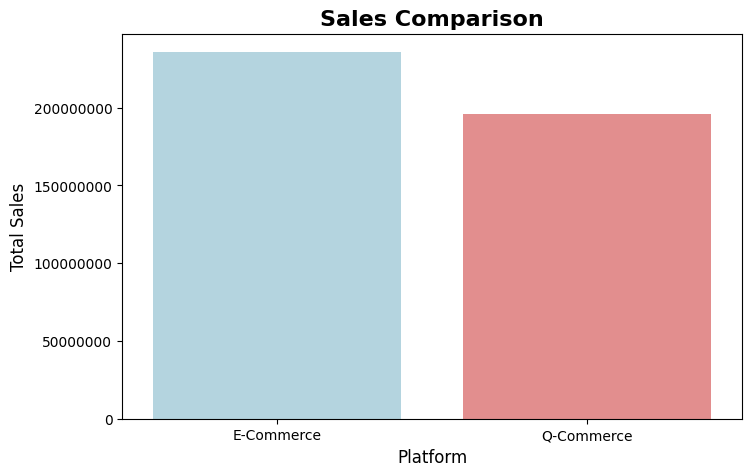

In [13]:
# Plot: Sales comparison between platforms
platform_sales = combined_df.groupby('Platform')['Sales'].sum()

plt.figure(figsize=(8, 5))
sns.barplot(x=platform_sales.index, y=platform_sales.values, palette=["lightblue", "lightcoral"], edgecolor=None)
plt.title("Sales Comparison", fontsize=16, fontweight='bold')
plt.ylabel("Total Sales", fontsize=12)
plt.xlabel("Platform", fontsize=12)
plt.grid(False)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

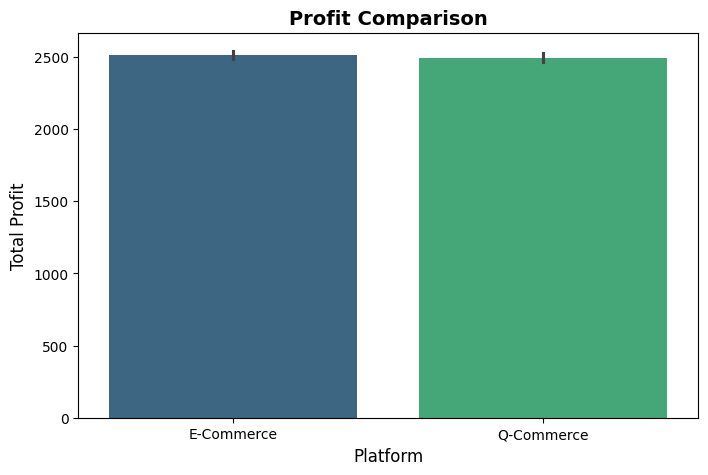

In [14]:
# Plot: Profit comparison between platforms
plt.figure(figsize=(8, 5))
sns.barplot(x=combined_df['Platform'], y=combined_df['Profit'], palette="viridis")
plt.title("Profit Comparison", fontsize=14, fontweight='bold')
plt.ylabel("Total Profit", fontsize=12)
plt.xlabel("Platform", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
plt.show()

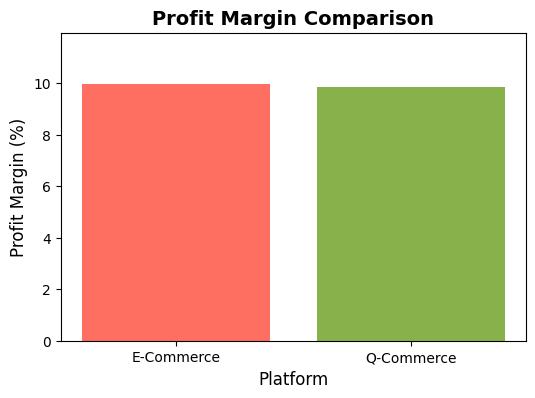

In [15]:
# Plot: Profit Margin Comparison
plt.figure(figsize=(6, 4))
profit_margins = {"E-Commerce": 9.96, "Q-Commerce": 9.87}
plt.bar(profit_margins.keys(), profit_margins.values(), color=['#FF6F61', '#88B04B'])
plt.xlabel("Platform", fontsize=12)
plt.ylabel("Profit Margin (%)", fontsize=12)
plt.title("Profit Margin Comparison", fontsize=14, fontweight='bold')
plt.ylim(0, max(profit_margins.values()) + 2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(False)
plt.show()

<Figure size 800x500 with 0 Axes>

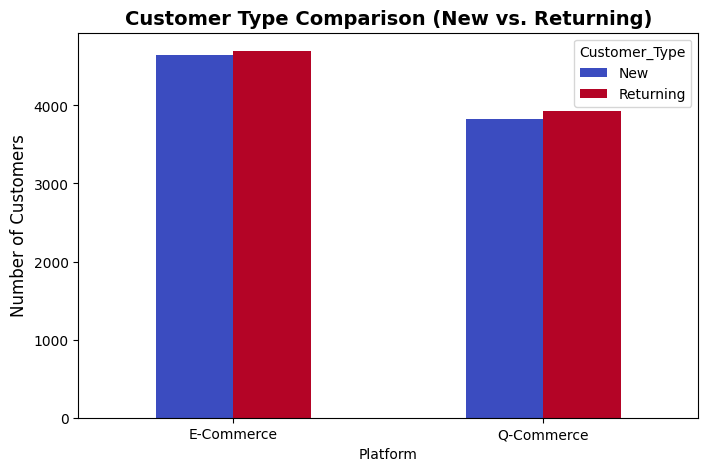

In [16]:
# Plot: Customer Type Comparison (New vs. Returning)
plt.figure(figsize=(8, 5))
customer_type_counts = combined_df.groupby(["Platform", "Customer_Type"]).size().unstack(fill_value=0)
customer_type_counts.plot(kind="bar", colormap="coolwarm", figsize=(8, 5))
plt.title("Customer Type Comparison (New vs. Returning)", fontsize=14, fontweight='bold')
plt.ylabel("Number of Customers", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(False)
plt.show()

<Figure size 800x500 with 0 Axes>

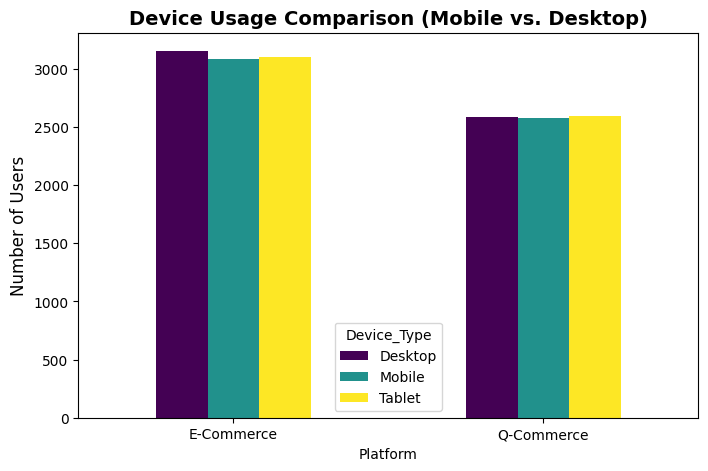

In [17]:
# Plot: Device Usage Comparison (Mobile vs. Desktop)
plt.figure(figsize=(8, 5))
device_type_counts = combined_df.groupby(["Platform", "Device_Type"]).size().unstack(fill_value=0)
device_type_counts.plot(kind="bar", colormap="viridis", figsize=(8, 5))
plt.title("Device Usage Comparison (Mobile vs. Desktop)", fontsize=14, fontweight='bold')
plt.ylabel("Number of Users", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(False)
plt.show()

<Figure size 800x500 with 0 Axes>

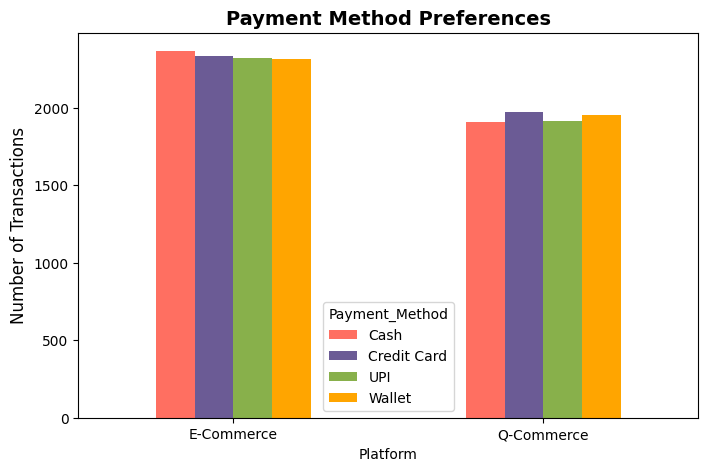

In [18]:
# Plot: Payment Method Preferences
plt.figure(figsize=(8, 5))
payment_method_counts = combined_df.groupby(["Platform", "Payment_Method"]).size().unstack(fill_value=0)
payment_method_counts.plot(kind="bar", figsize=(8, 5), color=["#FF6F61", "#6B5B95", "#88B04B", "#FFA500"])
plt.title("Payment Method Preferences", fontsize=14, fontweight='bold')
plt.ylabel("Number of Transactions", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(False)
plt.show()

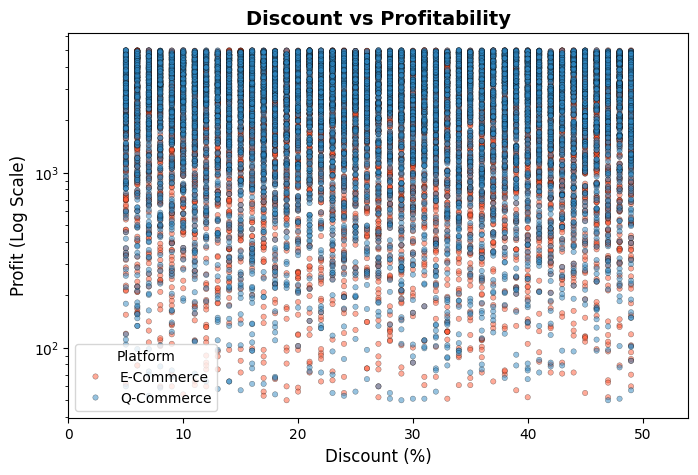

In [19]:
# Plot: Discount vs Profitability
plt.figure(figsize=(8, 5))
sns.scatterplot(data=combined_df, x="Discount", y="Profit", hue="Platform",
                palette=["#FF5733", "#2E86C1"], alpha=0.5, edgecolor="black", s=15)
plt.yscale("log")
plt.xlim(0, combined_df["Discount"].max() + 5)
plt.title("Discount vs Profitability", fontsize=14, fontweight='bold')
plt.xlabel("Discount (%)", fontsize=12)
plt.ylabel("Profit (Log Scale)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Platform", fontsize=10)
plt.grid(False)
plt.show()

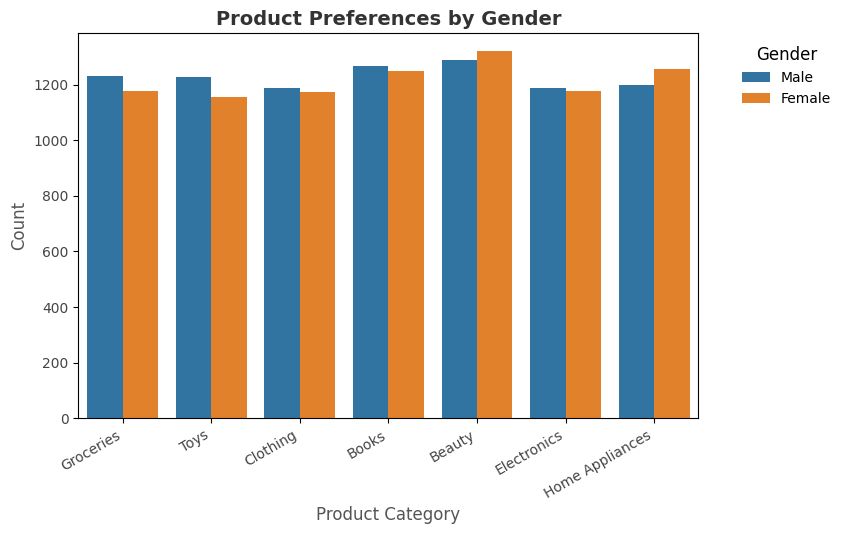

In [20]:
# Plot: Product Preferences by Gender
plt.figure(figsize=(8, 5))
sns.countplot(data=combined_df, x="Product_Category", hue="Gender", palette=["#1F77B4", "#FF7F0E"])
plt.title("Product Preferences by Gender", fontsize=14, fontweight='bold', color="#333333")
plt.xlabel("Product Category", fontsize=12, color="#555555")
plt.ylabel("Count", fontsize=12, color="#555555")
plt.xticks(rotation=30, ha="right", fontsize=10, color="#444444")
plt.yticks(fontsize=10, color="#444444")
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.legend(title="Gender", title_fontsize='12', fontsize=10, frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(False)
plt.show()

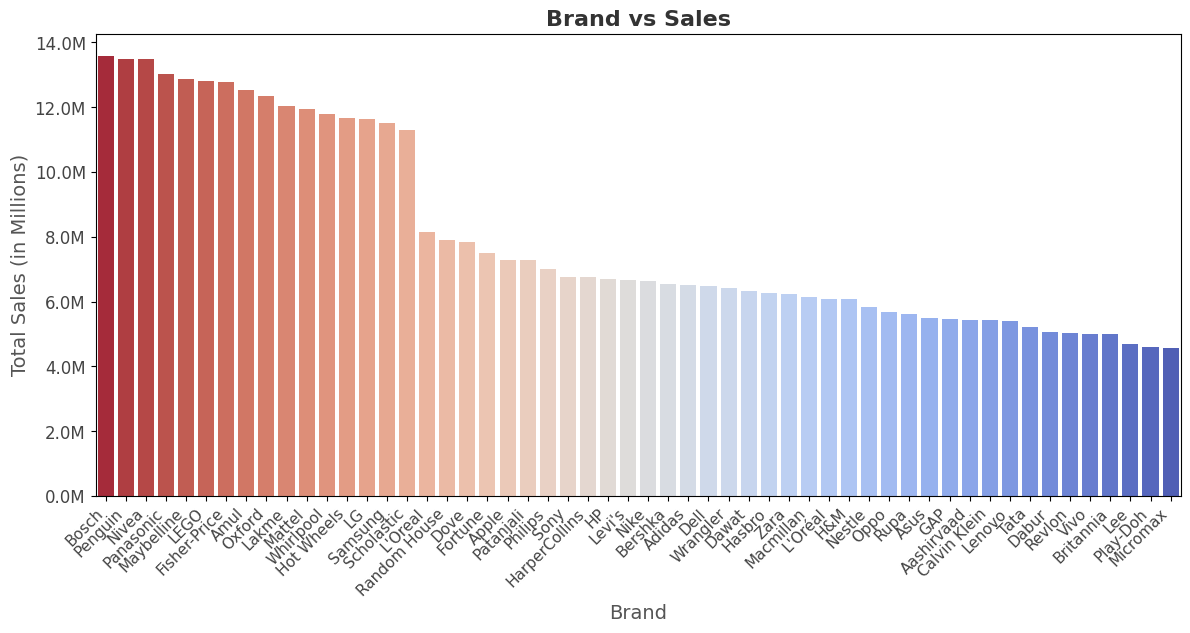

In [21]:
# Plot: Brand vs Sales
import matplotlib.ticker as mtick

brand_sales = combined_df.groupby("Brand")["Sales"].sum().sort_values(ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x=brand_sales.index, y=brand_sales.values, palette="coolwarm_r")
plt.title("Brand vs Sales", fontsize=16, fontweight="bold", color="#333333")
plt.ylabel("Total Sales (in Millions)", fontsize=14, color="#555555")
plt.xlabel("Brand", fontsize=14, color="#555555")
plt.xticks(rotation=45, fontsize=11, ha="right", color="#444444")
plt.yticks(fontsize=12, color="#444444")
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.grid(False)
plt.show()

In [22]:
# Encode categorical columns using LabelEncoder
cat_cols = ["Customer_Type", "Device_Type", "Payment_Method", "Order_Priority", "Platform"]
le = LabelEncoder()

for col in cat_cols:
    if col in combined_df.columns:
        combined_df[col] = le.fit_transform(combined_df[col])
    else:
        print(f"Warning: Column '{col}' not found in dataset.")

In [23]:
# Strip column names again in case any new ones were added with spaces
combined_df.columns = combined_df.columns.str.strip()

In [24]:
# Define features and target variable
features = ["Sales", "Profit", "Discount", "Shipping_Cost", "Quantity"]
target = "Profit"

# Ensure all selected features exist
features = [col for col in features if col in combined_df.columns]

# Split into X and y
X = combined_df[features]
y = combined_df[target]

# Display shapes
print(f"Feature Matrix Shape: {X.shape}")
print(f"Target Shape: {y.shape}")


Feature Matrix Shape: (17097, 5)
Target Shape: (17097,)


In [25]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Show shape of training and testing sets
print(f"Training Data: {X_train.shape}, Testing Data: {X_test.shape}")

Training Data: (13677, 5), Testing Data: (3420, 5)


In [26]:
# Initialize and train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [27]:
# Make predictions on the test set
y_pred = model.predict(X_test)

In [28]:
# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print("Linear Regression Metrics:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R² Score: {r2}")

Linear Regression Metrics:
MAE: 1.1122549275361897e-12
MSE: 1.6609659856398044e-24
R² Score: 1.0


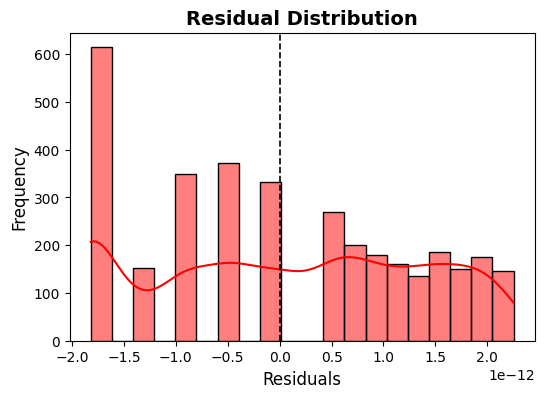

In [29]:
# Plot the distribution of residuals
residuals = y_test - y_pred

plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=20, kde=True, color="red")
plt.axvline(0, color="black", linestyle="--", linewidth=1.2)
plt.title("Residual Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(False)
plt.show()

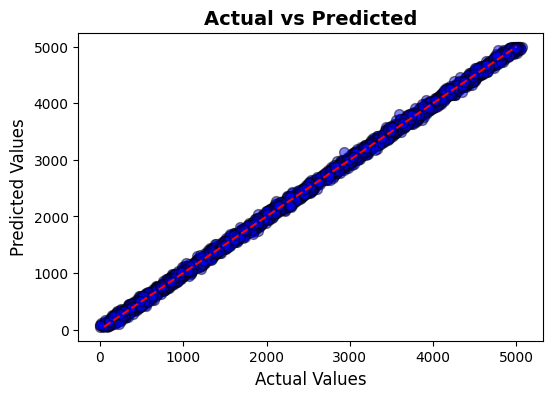

In [30]:
# Plot: Actual vs Predicted with jitter for better visibility
plt.figure(figsize=(6, 4))
jitter = np.random.normal(0, (max(y_test) - min(y_test)) * 0.01, size=len(y_test))

plt.scatter(y_test + jitter, y_pred, color="blue", alpha=0.5, edgecolors="black", s=50)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--", linewidth=1.5)
plt.title("Actual vs Predicted", fontsize=14, fontweight="bold")
plt.xlabel("Actual Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.grid(False)
plt.show()

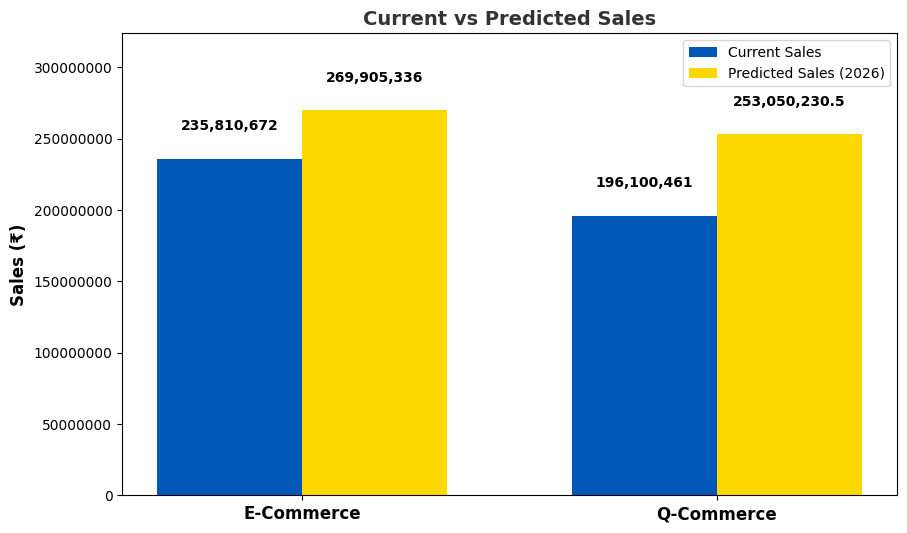

In [31]:
# Current vs Predicted Sales Comparison (2026)
platforms = ["E-Commerce", "Q-Commerce"]
current_sales = [235810672, 196100461]
predicted_sales_values = [269905336, 253050230.5]

bar_width = 0.35
x = np.arange(len(platforms))

plt.figure(figsize=(10, 6))
plt.bar(x - bar_width/2, current_sales, bar_width, label="Current Sales", color="#0057B7")
plt.bar(x + bar_width/2, predicted_sales_values, bar_width, label="Predicted Sales (2026)", color="#FFD700")

plt.xticks(x, platforms, fontsize=12, fontweight='bold')
plt.ylabel("Sales (₹)", fontsize=12, fontweight="bold")
plt.title("Current vs Predicted Sales", fontsize=14, fontweight="bold", color="#333333")
plt.legend(fontsize=10)
plt.ticklabel_format(style='plain', axis='y')

for i, v in enumerate(current_sales):
    plt.text(x[i] - bar_width/2, v + 20000000, f"{v:,}", ha='center', fontsize=10, fontweight='bold', color="black")

for i, v in enumerate(predicted_sales_values):
    plt.text(x[i] + bar_width/2, v + 20000000, f"{v:,}", ha='center', fontsize=10, fontweight='bold', color="black")

plt.ylim(0, max(predicted_sales_values) * 1.2)
plt.show()


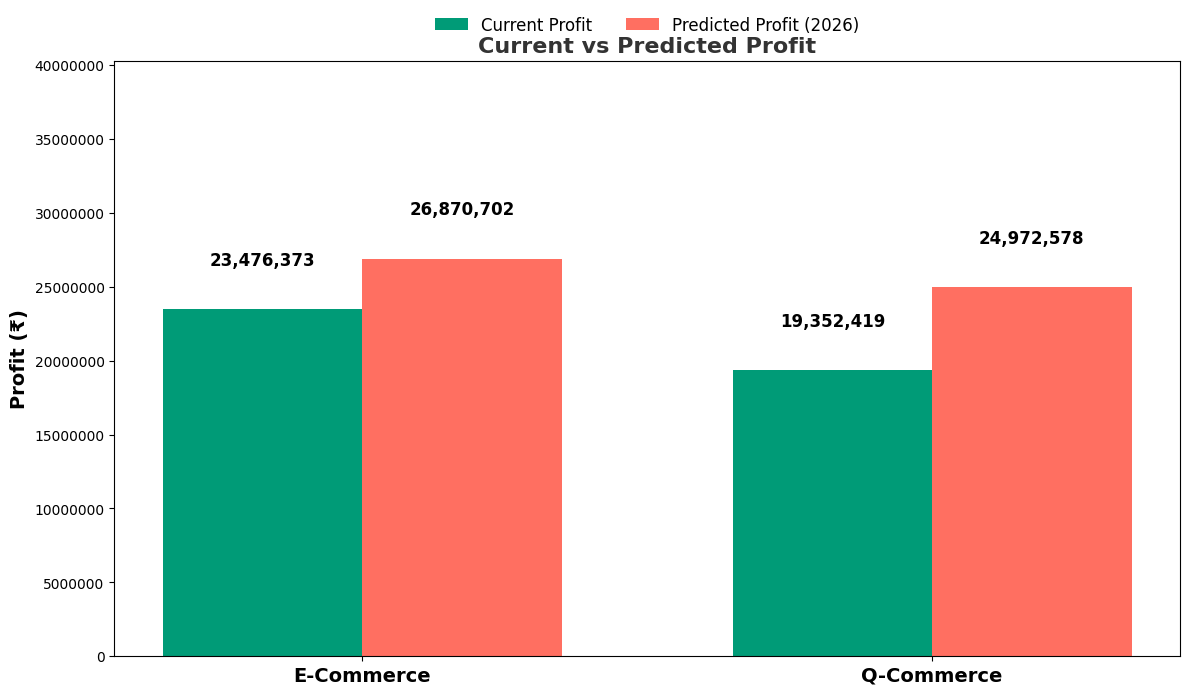

In [32]:
# Current vs Predicted Profit Comparison (2026)
platforms = ["E-Commerce", "Q-Commerce"]
current_sales = [235810672, 196100461]
current_profit = [23476373, 19352419]
predicted_sales = [269905336, 253050230.5]

# Calculate profit margins and predicted profits
profit_margin = [current_profit[i] / current_sales[i] for i in range(len(platforms))]
predicted_profit_values = [predicted_sales[i] * profit_margin[i] for i in range(len(platforms))]

bar_width = 0.35
x = np.arange(len(platforms))

plt.figure(figsize=(12, 7))
bars1 = plt.bar(x - bar_width/2, current_profit, bar_width, label="Current Profit", color="#009B77")
bars2 = plt.bar(x + bar_width/2, predicted_profit_values, bar_width, label="Predicted Profit (2026)", color="#FF6F61")

plt.xticks(x, platforms, fontsize=14, fontweight='bold')
plt.ylabel("Profit (₹)", fontsize=14, fontweight="bold")
plt.title("Current vs Predicted Profit", fontsize=16, fontweight="bold", color="#333333")
plt.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2, frameon=False)
plt.ticklabel_format(style='plain', axis='y')

for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 3000000, f"{int(yval):,}", ha='center', fontsize=12, fontweight='bold', color="black")

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 3000000, f"{int(yval):,}", ha='center', fontsize=12, fontweight='bold', color="black")

plt.ylim(0, max(max(current_profit), max(predicted_profit_values)) * 1.5)
plt.tight_layout()
plt.show()

In [35]:
# Perform Chi-Square tests on categorical variable pairs (excluding specified ones)
categorical_cols = combined_df.select_dtypes(include=['object']).columns.tolist()
exclude_pairs = [("Product", "Brand"), ("Brand", "Platform")]

chi_square_results = []

for col1, col2 in combinations(categorical_cols, 2):
    if (col1, col2) in exclude_pairs or (col2, col1) in exclude_pairs:
        continue

    contingency_table = pd.crosstab(combined_df[col1], combined_df[col2])

    if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
        chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
        chi_square_results.append({
            "Variable 1": col1,
            "Variable 2": col2,
            "Chi-Square Statistic": chi2_stat,
            "P-Value": p_value,
            "Degrees of Freedom": dof,
            "Significant": "✔" if p_value < 0.05 else "✘"
        })

chi_square_results_df = pd.DataFrame(chi_square_results)
significant_results = chi_square_results_df[chi_square_results_df["Significant"] == "✔"]
print(significant_results)

         Variable 1 Variable 2  Chi-Square Statistic  P-Value  \
3  Product_Category    Product         102582.000000      0.0   
4  Product_Category      Brand         100916.738238      0.0   

   Degrees of Freedom Significant  
3                 204           ✔  
4                 318           ✔  


<Figure size 2000x1200 with 0 Axes>

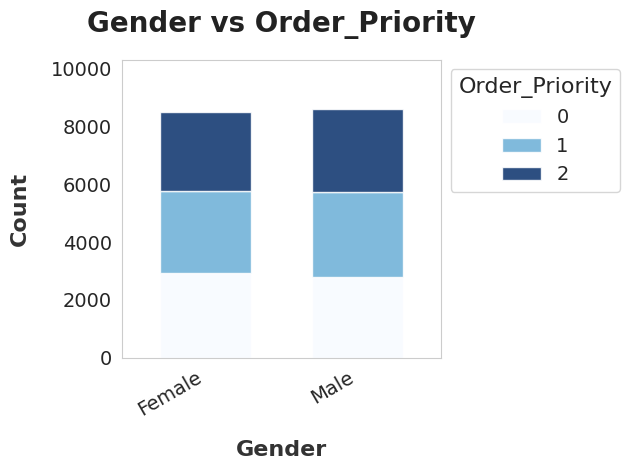

<Figure size 2000x1200 with 0 Axes>

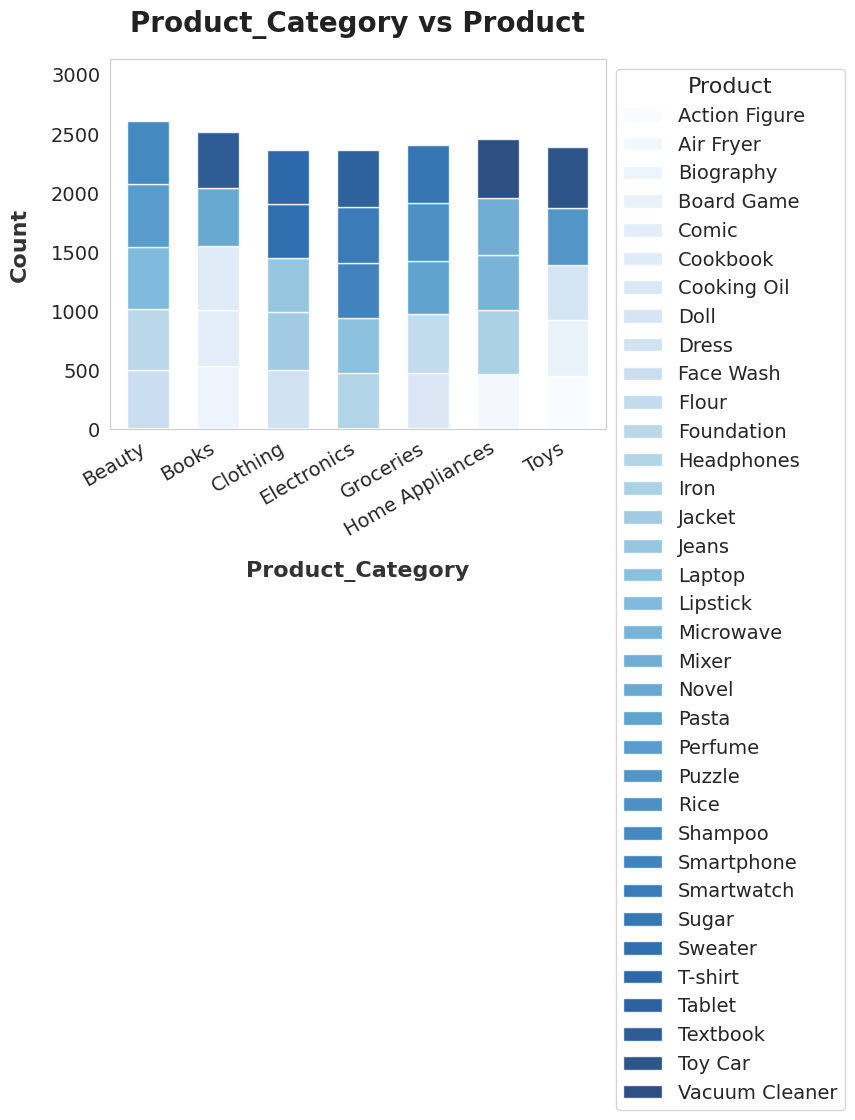

In [37]:
# Visualize significant categorical variable pairs (1st round)
significant_pairs = [
    ("Gender", "Order_Priority"),
    ("Product_Category", "Product")
]

sns.set_style("whitegrid")

for var1, var2 in significant_pairs:
    plt.figure(figsize=(20, 12))
    contingency_table = pd.crosstab(combined_df[var1], combined_df[var2])

    if contingency_table.shape[0] > 10:
        contingency_table.plot(kind="barh", stacked=True, colormap="Blues", alpha=0.85, width=0.7)
        plt.xlabel("Count", fontsize=16, fontweight="bold", color="#333333", labelpad=15)
        plt.ylabel(var1, fontsize=16, fontweight="bold", color="#333333", labelpad=15)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
    else:
        contingency_table.plot(kind="bar", stacked=True, colormap="Blues", alpha=0.85, width=0.6)
        plt.xlabel(var1, fontsize=16, fontweight="bold", color="#333333", labelpad=15)
        plt.ylabel("Count", fontsize=16, fontweight="bold", color="#333333", labelpad=15)
        plt.xticks(rotation=30, ha="right", fontsize=14)
        plt.yticks(fontsize=14)

    plt.title(f"{var1} vs {var2}", fontsize=20, fontweight="bold", color="#222222", pad=20)
    plt.legend(title=var2, loc="upper left", bbox_to_anchor=(1, 1), fontsize=14, title_fontsize=16)
    plt.margins(x=0.1, y=0.2)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

<Figure size 2000x1200 with 0 Axes>

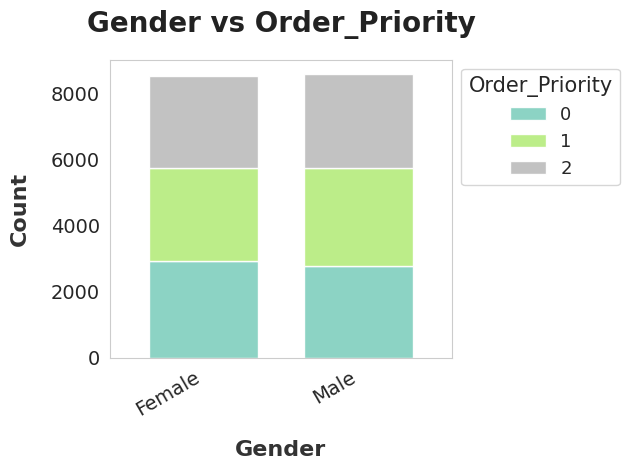

<Figure size 2000x1200 with 0 Axes>

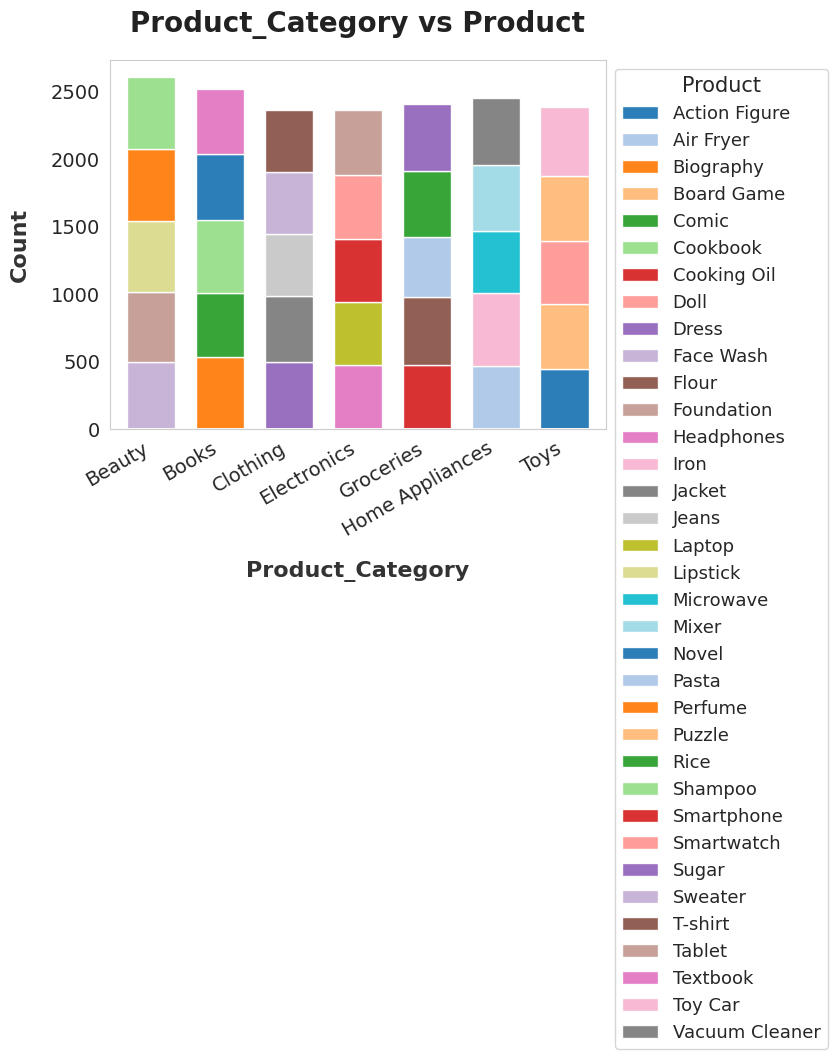

<Figure size 2000x1200 with 0 Axes>

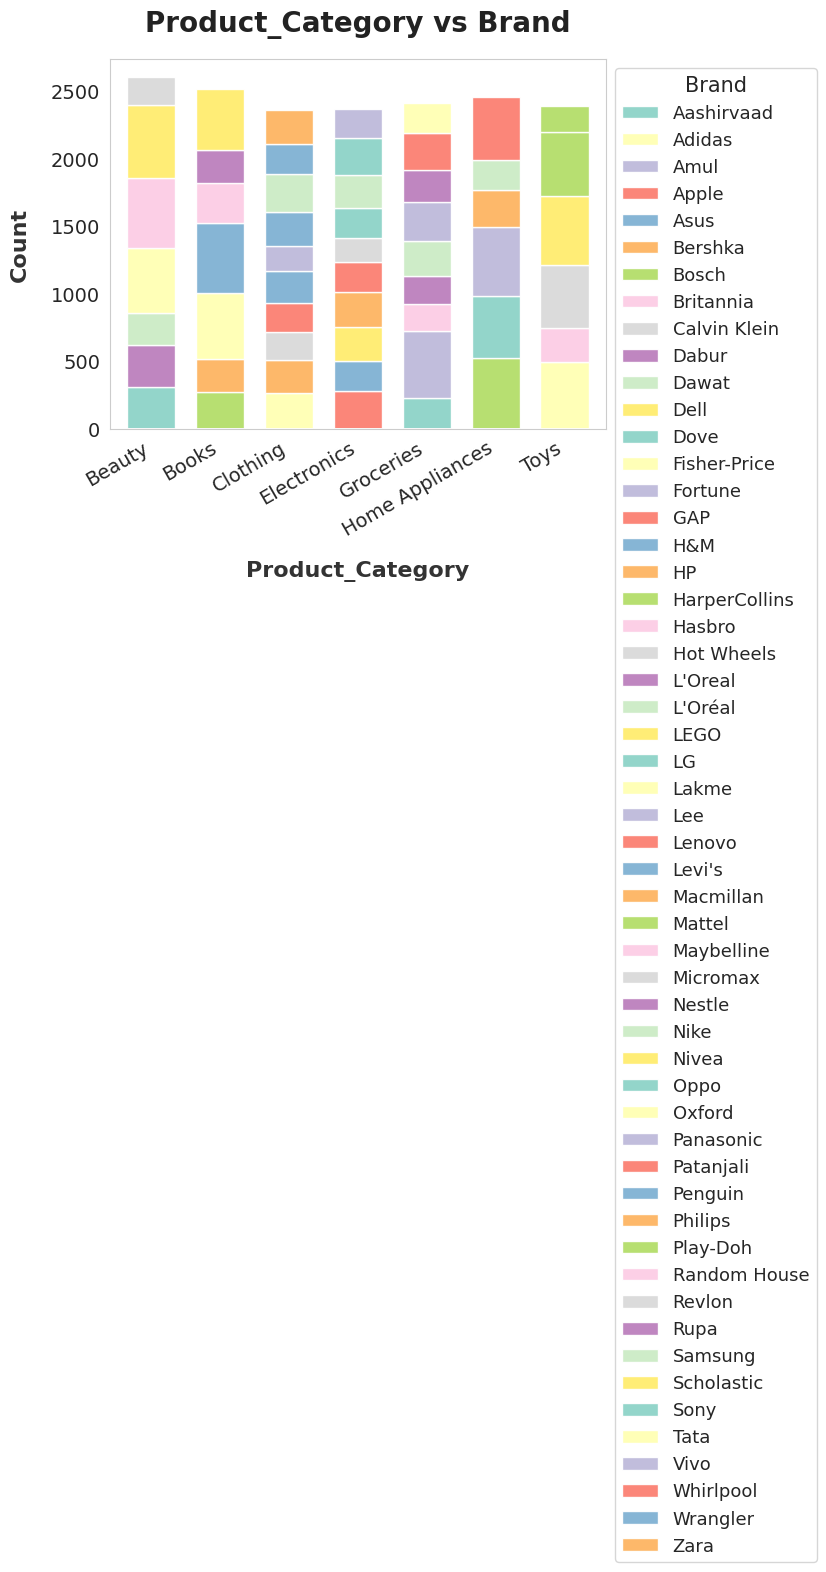

In [39]:
# Visualize more significant categorical pairs with custom colors
significant_pairs = [
    ("Gender", "Order_Priority"),
    ("Product_Category", "Product"),
    ("Product_Category", "Brand")
]

custom_palettes = {
    "Order_Priority": ["#86d1c1", "#b9ed83", "#bfbfbf"],
    "Product": sns.color_palette("tab20", n_colors=combined_df["Product"].nunique()),
    "Brand": sns.color_palette("Set3", n_colors=combined_df["Brand"].nunique())
}

sns.set_style("whitegrid")

for var1, var2 in significant_pairs:
    plt.figure(figsize=(20, 12))
    contingency_table = pd.crosstab(combined_df[var1], combined_df[var2])
    palette = custom_palettes.get(var2, None)

    contingency_table.plot(
        kind="bar",
        stacked=True,
        alpha=0.95,
        width=0.7,
        color=palette
    )

    plt.xlabel(var1, fontsize=16, fontweight="bold", color="#333333", labelpad=15)
    plt.ylabel("Count", fontsize=16, fontweight="bold", color="#333333", labelpad=15)
    plt.xticks(rotation=30, ha="right", fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f"{var1} vs {var2}", fontsize=20, fontweight="bold", color="#222222", pad=20)
    plt.legend(title=var2, loc="upper left", bbox_to_anchor=(1, 1), fontsize=13, title_fontsize=15)
    plt.grid(False)
    plt.tight_layout()
    plt.show()